In [10]:
import torch
import numpy as np
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
%matplotlib inline

### Markov Decision Process

In [3]:
from typing import Tuple, Dict, Optional, Iterable

import numpy as np
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


### Creating environment

In [5]:
env = Maze()

In [12]:
# env.reset() : make initial state
initial_state = env.reset()
initial_state

(0, 0)

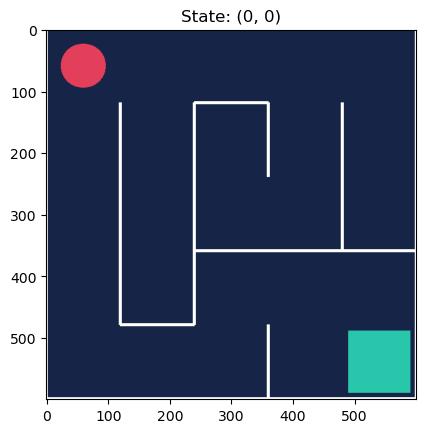

In [14]:
# env.render()
frame = env.render(mode='rgb_array')
plt.title(f'State: {initial_state}')
plt.imshow(frame)

In [36]:
# env.step() : applies action, returns next state, reward, if task completed, info
action = 2 # action 0: up, 1: right, 2: down, 3: left
next_state, reward, done, info = env.step(action)
print(f'State: {next_state}')
print(f'Reward: {reward}')

State: (4, 4)
Reward: -1.0


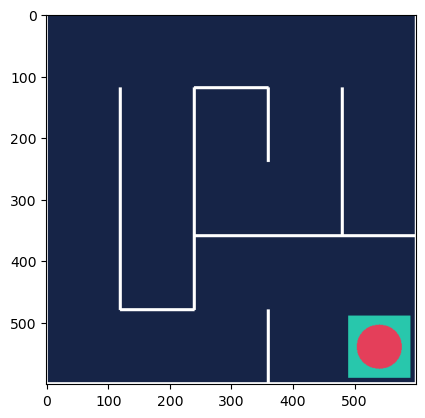

In [37]:
plt.imshow(env.render())

In [38]:
env.close()

## Maze environment: Find the exit.


In this section we are going to familiarize ourselves with the environment that we'll use in the lessons 2 (dynamic programming), 3 (Monte Carlo methods) and 4 (temporal difference methods). This environment is perfect for learning the basics of Reinforcement Learning because:

- It has few states (25)
- Transitions between states are deterministic ($p(s', r| s, a) = 1$)
- All rewards are the same (-1) until the episode concludes. Thus facilitating the study of the value and action-value functions

Through this environment, we are going to review the concepts seen in lesson 1 (The Markov decision process):

- States and state space
- Actions and action space
- Trajectories and episodes
- Rewards and returns
- Policy


The environment is a maze of 5x5 cells, in which the goal of the agent is to find the exit, located in the lower right corner, in the cell (4,4). In the image, the exit is colored in light green.

To reach the exit, the agent can take four different actions: move up, move down, move left and move right.

##### States and state space

The states consist of a tuple of two integers, both in the range [0, 4], representing the row and column in which the agent is currently located:
<br>
<br>

\begin{equation}
    s = (row, column) \;\\
    row, column \in \{0,1,2,3, 4\}
\end{equation}
<br>
<br>
The state space (set of all possible states in the task) has 25 elements (all possible combinations of rows and columns):


\begin{equation}
    Rows \times Columns \;\\
    S = \{(0, 0), (0, 1), (1, 0), ...\}
\end{equation}

Information about the state space is stored in the env.observation_space property. In this environment, it is of MultiDiscrete([5 5]) type, which means that it consists of two elements (rows and columns), each with 5 different values.

##### Actions and action space

In this environment, there are four different actions and they are represented by integers:

\begin{equation}
a \in \{0, 1, 2, 3\}
\end{equation}

- 0 -> move up
- 1 -> move right
- 2 -> move down
- 3 -> move left

To execute an action, simply pass it as an argument to the env.step method. Information about the action space is stored in the env.action_space property which is of Discrete(4) class. This means that in this case it only consists of an element in the range [0,4), unlike the state space seen above.


##### Trajectories and episodes

A trajectory is the sequence generated by moving from one state to another (both arbitrary)

\begin{equation}
  \tau = S_0, A_0, R_1, S_1, A_1, ... R_N, S_N,
\end{equation}

Let's generate a trajectory of 3 moves in code:

##### Rewards and returns

A reward is numerical feedback that the environment generates when the agent takes an action *a* in a state *s*:

\begin{equation}
    r = r(s, a)
\end{equation}

Let's generate a reward from the environment:

The return associated with a moment in time *t* is the sum (discounted) of rewards that the agent obtains from that moment. We are going to calculate $G_0$, that is, the return to the beginning of the episode:

\begin{equation}
    G_0 = R_1 + \gamma R_2 + \gamma^2 R_3 + ... + \gamma^{T-1} R_T
\end{equation}



Let's assume that the discount factor $\gamma = 0.99$:


##### Policy

A policy is a function $\pi(a|s) \in [0, 1]$ that gives the probability of an action given the current state. The function takes the state and action as inputs and returns a float in [0,1].

Since in practice we will need to compute the probabilities of all actions, we will represent the policy as a function that takes the state as an argument and returns the probabilities associated with each of the actions. Thus, if the probabilities are:

[0.5, 0.3, 0.1]

we will understand that the action with index 0 has a 50% probability of being chosen, the one with index 1 has 30% and the one with index 2 has 10%.

Let's code a policy function that chooses actions randomly:

In [67]:
# create env
env = Maze()

In [68]:
print(f'Initial state: {env.reset()}')

Initial state: (0, 0)


In [69]:
env.observation_space # state space

MultiDiscrete([5 5])

In [70]:
env.action_space # action space

Discrete(4)

In [71]:
env.action_space.sample() # random action

0

In [75]:
env = Maze()
state = env.reset()

# create trajectory
trajectory = []

for i in range(5):
    action = env.action_space.sample() # generate random action
    next_state, reward, is_finished, info = env.step(action)
    trajectory.append([state, action, reward, is_finished, next_state])
    state = next_state
env.close()

trajectory

[[(0, 0), 3, -1.0, False, (0, 0)],
 [(0, 0), 2, -1.0, False, (1, 0)],
 [(1, 0), 1, -1.0, False, (1, 0)],
 [(1, 0), 2, -1.0, False, (2, 0)],
 [(2, 0), 0, -1.0, False, (1, 0)]]

In [95]:
is_finished = 0

env = Maze()
state = env.reset()

# create episode : trajectory from initial state to final state
episode = []

while not is_finished:
    action = env.action_space.sample() # generate random action
    next_state, reward, is_finished, info = env.step(action)
    episode.append([state, action, reward, is_finished, next_state])
    state = next_state
env.close()

print(f'Length : {len(episode)}')
episode[-10:]

Length : 263


[[(4, 2), 0, -1.0, False, (3, 2)],
 [(3, 2), 1, -1.0, False, (3, 3)],
 [(3, 3), 0, -1.0, False, (3, 3)],
 [(3, 3), 1, -1.0, False, (3, 4)],
 [(3, 4), 0, -1.0, False, (3, 4)],
 [(3, 4), 0, -1.0, False, (3, 4)],
 [(3, 4), 1, -1.0, False, (3, 4)],
 [(3, 4), 1, -1.0, False, (3, 4)],
 [(3, 4), 0, -1.0, False, (3, 4)],
 [(3, 4), 2, -1.0, True, (4, 4)]]

In [101]:
is_finished = 0

env = Maze()
state = env.reset()
gamma = 0.99
G_0 = 0
t = 0

# calculate return

while not is_finished:
    action = env.action_space.sample() # generate random action
    next_state, reward, is_finished, info = env.step(action)
    G_0 += gamma**t * reward
    t += 1
env.close()

print(f'It tooks t={t}, return amounts G_0={G_0}')

It tooks t=200, return amounts G_0=-86.6020325142037


<BarContainer object of 4 artists>

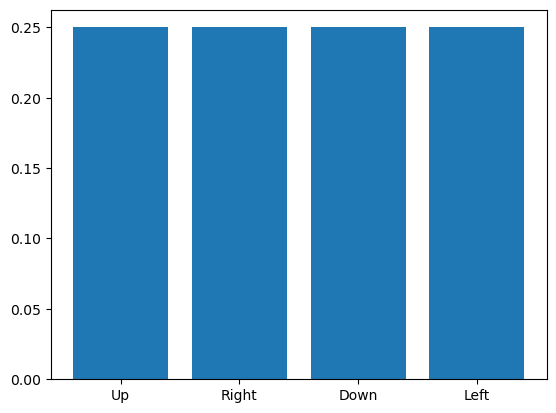

In [105]:
# policy
def random_policy(state):
    return np.array([0.25] * 4)

env = Maze()
state = env.reset()

action_probabilities = random_policy(state)
objects = np.array(['Up', 'Right', 'Down', 'Left'])
plt.bar(objects, action_probabilities)

KeyboardInterrupt: 

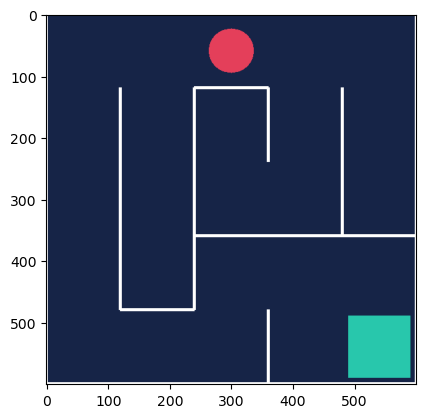

In [108]:
from IPython import display

env = Maze()
state = env.reset()
is_finished = 0

# using policy when training
img = plt.imshow(env.render())
while not is_finished:
    action = np.random.choice(range(4), 1, p=action_probabilities)
    _, _, is_finished, _ = env.step(action)
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
env.close()